Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Analyze Image Data

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 💾 Folder with all images directly inside
image_folder = "/content/drive/My Drive/Rock_Paper_Scissors_Dataset"

image_shapes = []
corrupt_images = []
image_formats = []

# 🔁 Loop through all files
for filename in tqdm(os.listdir(image_folder)):
    file_path = os.path.join(image_folder, filename)

    if os.path.isfile(file_path):
        try:
            with Image.open(file_path) as img:
                image_shapes.append(img.size)
                image_formats.append(img.format)
        except:
            corrupt_images.append(filename)

# 📊 Check if any valid images found
if len(image_shapes) > 0:
    widths, heights = zip(*image_shapes)
else:
    print("⚠️ No valid images found. Please check folder path and contents.")

100%|██████████| 304/304 [00:04<00:00, 68.89it/s] 


Visualize Image Distribution

🖼️ Total usable images: 304
⚠️ Corrupt/unreadable images: 0
📐 Unique image sizes: {(640, 640)}
🧾 Image formats used: {'JPEG'}


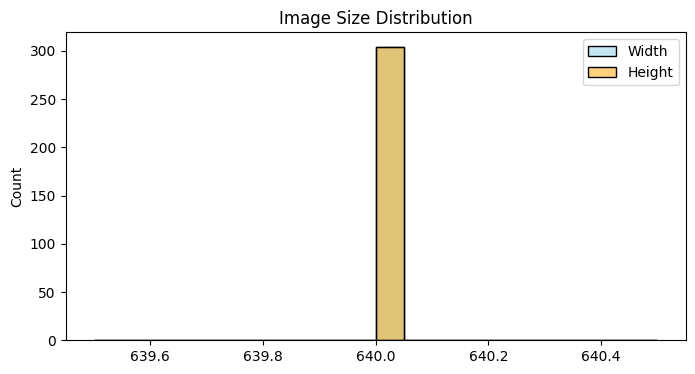

In [3]:
# 📊 Summary
print(f"🖼️ Total usable images: {len(image_shapes)}")
print(f"⚠️ Corrupt/unreadable images: {len(corrupt_images)}")
print(f"📐 Unique image sizes: {set(image_shapes)}")
print(f"🧾 Image formats used: {set(image_formats)}")

# 📈 Image dimension plots
import numpy as np

if len(image_shapes) > 0:
    plt.figure(figsize=(8, 4))
    sns.histplot(widths, bins=20, kde=True, color="skyblue", label="Width")
    sns.histplot(heights, bins=20, kde=True, color="orange", label="Height")
    plt.title("Image Size Distribution")
    plt.legend()
    plt.show()

Python Code for Cropping + Saving Images

In [4]:
import pandas as pd
import os
from PIL import Image

# ✅ Paths
csv_path = "/content/drive/MyDrive/_annotations.csv"
img_dir = "/content/drive/My Drive/Rock_Paper_Scissors_Dataset"
output_dir = "/content/Processed_RPS"

# 📄 Load CSV
df = pd.read_csv(csv_path)

# 🔁 Loop and crop
for idx, row in df.iterrows():
    filename = row['filename']
    class_name = row['class']
    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])

    img_path = os.path.join(img_dir, filename)
    out_class_dir = os.path.join(output_dir, class_name)
    os.makedirs(out_class_dir, exist_ok=True)

    try:
        with Image.open(img_path) as img:
            cropped = img.crop((xmin, ymin, xmax, ymax))
            save_path = os.path.join(out_class_dir, filename)
            cropped.save(save_path)
    except Exception as e:
        print(f"❌ Failed on {filename}: {e}")

Quick Sanity Check

📊 Image count per class:

  Rock: 59 images
  Scissors: 66 images
  Paper: 72 images

🖼️ Displaying samples...


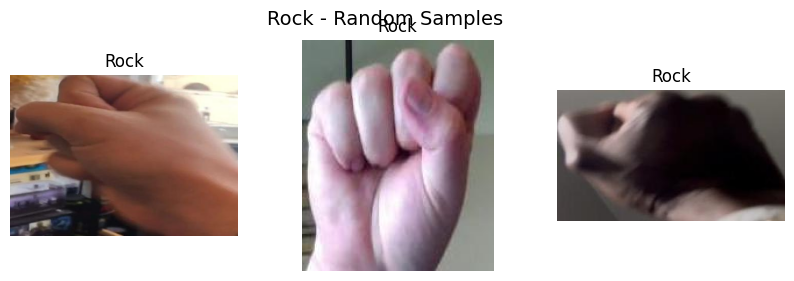

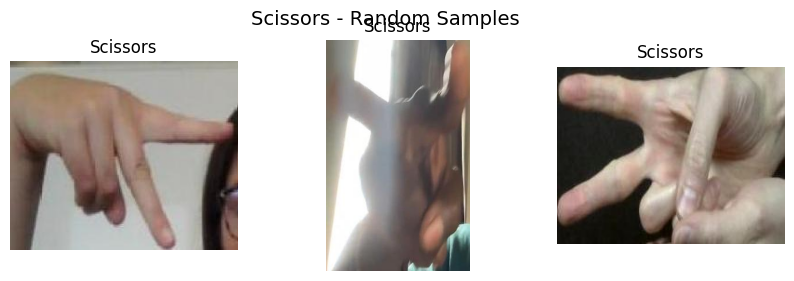

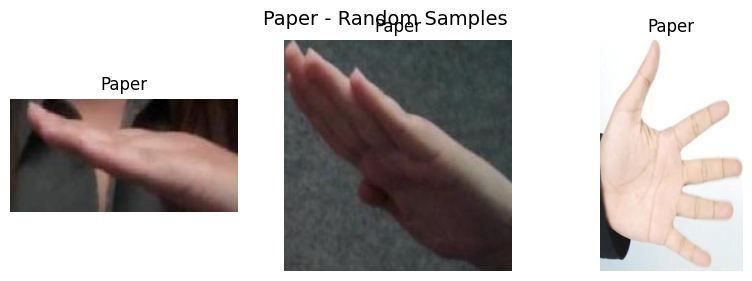

In [5]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# 🔎 Path to processed folder
processed_path = "/content/Processed_RPS"

# ✅ Count images per class
print("📊 Image count per class:\n")
for class_name in os.listdir(processed_path):
    class_dir = os.path.join(processed_path, class_name)
    if os.path.isdir(class_dir):
        img_count = len(os.listdir(class_dir))
        print(f"  {class_name}: {img_count} images")

# 👁️ Show 3 random samples per class
print("\n🖼️ Displaying samples...")
for class_name in os.listdir(processed_path):
    class_dir = os.path.join(processed_path, class_name)
    images = os.listdir(class_dir)
    if len(images) < 3:
        continue

    sample_imgs = random.sample(images, 3)

    plt.figure(figsize=(10, 3))
    for i, img_name in enumerate(sample_imgs):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(f"{class_name}")
        plt.axis('off')
    plt.suptitle(f"{class_name} - Random Samples", fontsize=14)
    plt.show()

Load Dataset using `ImageDataGenerator`

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base path
data_path = "/content/Processed_RPS"

# Image size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# 🧪 Augment + Normalize
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, # 80-20 split
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_gen = train_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 159 images belonging to 3 classes.
Found 38 images belonging to 3 classes.


CNN Model for Rock Paper Scissors

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: Rock, Paper, Scissors
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Training Code

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 🛑 Stop if val loss doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 💾 Save best model to file
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)

# 🚀 Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.3441 - loss: 1.1219

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3465 - loss: 1.1209 - val_accuracy: 0.3684 - val_loss: 1.0925
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3491 - loss: 1.1049 - val_accuracy: 0.3684 - val_loss: 1.0961
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4031 - loss: 1.0935 - val_accuracy: 0.2895 - val_loss: 1.0948
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3893 - loss: 1.0752 - val_accuracy: 0.3421 - val_loss: 1.0908
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3961 - loss: 1.0793 - val_accuracy: 0.2632 - val_loss: 1.0908
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3417 - loss: 1.0950 - val_accuracy: 0.3158 - val_loss: 1.0880
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3954 - loss: 1.0723 - val_accuracy: 0.2632 - val_loss: 1.0862
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4127 - loss: 1.0662 - val_accuracy: 0.3158 - val_loss: 1.0816
Epoch 9/25
5/5 ━━━━━━━━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4829 - loss: 1.0271 - val_accuracy: 0.4474 - val_loss: 1.0686
Epoch 13/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4988 - loss: 1.0251 - val_accuracy: 0.3158 - val_loss: 1.0594
Epoch 14/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4817 - loss: 1.0414

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4895 - loss: 1.0385 - val_accuracy: 0.4737 - val_loss: 1.0461
Epoch 15/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5142 - loss: 0.9992 - val_accuracy: 0.4474 - val_loss: 1.0490
Epoch 16/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5307 - loss: 0.9766 - val_accuracy: 0.3158 - val_loss: 1.0578
Epoch 17/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.5427 - loss: 0.9422

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5361 - loss: 0.9471 - val_accuracy: 0.5000 - val_loss: 1.0332
Epoch 18/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5362 - loss: 0.9419 - val_accuracy: 0.4737 - val_loss: 1.0314
Epoch 19/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5001 - loss: 0.9973 - val_accuracy: 0.4474 - val_loss: 1.0340
Epoch 20/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5543 - loss: 0.9492 - val_accuracy: 0.4474 - val_loss: 1.0253
Epoch 21/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5973 - loss: 0.9480 - val_accuracy: 0.3947 - val_loss: 1.0354
Epoch 22/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6472 - loss: 0.9008 - val_accuracy: 0.5000 - val_loss: 1.0367
Epoch 23/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5515 - loss: 0.9671 - val_accuracy: 0.4474 - val_loss: 1.0404
Epoch 24/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5747 - loss: 0.9299 - val_accuracy: 0.4474 - val_loss: 1.0342
Epoch 25/25
5/5 ━━━

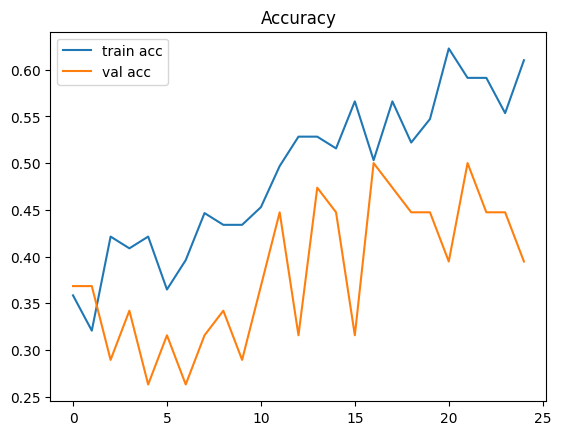

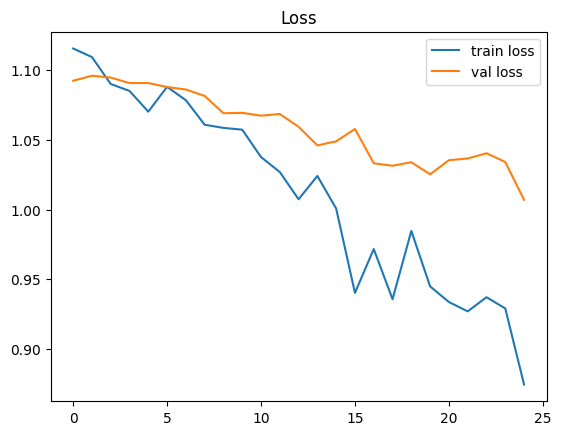

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

**Transfer Learning with MobileNetV2**

set folders

In [11]:
import os
import shutil
import random

# Existing folder
source_dir = '/content/Processed_RPS'  # Your current dataset

# Target structure
target_dir = '/content/dataset'
categories = ['Rock', 'Paper', 'Scissors']
split_ratio = 0.8  # 80% train, 20% val

# Create train/ and val/ directories with subfolders
for split in ['train', 'val']:
    for category in categories:
        os.makedirs(os.path.join(target_dir, split, category), exist_ok=True)

# Move files
for category in categories:
    full_path = os.path.join(source_dir, category)
    images = os.listdir(full_path)
    random.shuffle(images)

    split_idx = int(len(images) * split_ratio)
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    for img in train_imgs:
        shutil.copy(os.path.join(full_path, img), os.path.join(target_dir, 'train', category, img))

    for img in val_imgs:
        shutil.copy(os.path.join(full_path, img), os.path.join(target_dir, 'val', category, img))

print("✅ Dataset split and copied to /content/dataset")

✅ Dataset split and copied to /content/dataset


Build the MobileNetV2 Transfer Model

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the base layers

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the Model

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    # EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=callbacks
)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step - accuracy: 0.7976 - loss: 0.4943 - val_accuracy: 0.6842 - val_loss: 0.6647 - learning_rate: 7.8125e-07
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - accuracy: 0.8275 - loss: 0.4128 - val_accuracy: 0.6579 - val_loss: 0.6710 - learning_rate: 7.8125e-07
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 743ms/step - accuracy: 0.8331 - loss: 0.4093 - val_accuracy: 0.7895 - val_loss: 0.5353 - learning_rate: 7.8125e-07
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - accuracy: 0.8111 - loss: 0.5127 - val_accuracy: 0.7368 - val_loss: 0.6329 - learning_rate: 7.8125e-07
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - accuracy: 0.8866 - loss: 0.4083 - val_accuracy: 0.7105 - val_loss: 0.6431 - learning_rate: 7.8125e-07
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - accuracy: 0.8517 - loss: 0.4744 - val_accuracy: 0.7632 - val_loss: 0.5434 - learning_rate: 7.8125e-07
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 813ms/step - accuracy: 0.7874 - loss:

In [20]:
model.save("mobilenetv2_rps.h5")

# GRADIO APP

In [21]:
!pip install gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.6 MB/s eta 0:00:00


In [33]:
import tensorflow as tf
import numpy as np
import gradio as gr
from PIL import Image
import random

# Load your trained model
model = tf.keras.models.load_model("mobilenetv2_rps.h5")
labels = ['rock', 'paper', 'scissors']

def preprocess(image):
    image = image.resize((128, 128))
    image = np.array(image) / 255.0
    image = image.reshape(1, 128, 128, 3)
    return image

def get_winner(player, ai):
    if player == ai:
        return "It's a tie! 🤝"
    elif (player == "rock" and ai == "scissors") or \
         (player == "scissors" and ai == "paper") or \
         (player == "paper" and ai == "rock"):
        return "You win! 🎉"
    else:
        return "AI wins! 🤖"

def play_rps(image):
    if image is None:
        return "None", "None", "Please upload or draw your move!"

    preprocessed = preprocess(image)
    prediction = model.predict(preprocessed)[0]
    player_move = labels[np.argmax(prediction)]
    ai_move = random.choice(labels)
    result = get_winner(player_move, ai_move)

    return player_move, ai_move, result

# Gradio UI
interface = gr.Interface(
    fn=play_rps,
    inputs=gr.Image(label="Upload or Draw Your Hand Sign (Rock / Paper / Scissors)", type="pil"),
    outputs=[
        gr.Textbox(label="🧍 Your Move"),
        gr.Textbox(label="🤖 AI's Move"),
        gr.Textbox(label="🏆 Result")
    ],
    title="Rock Paper Scissors Game 🎮",
    description="Upload a picture showing your move (Rock, Paper, or Scissors). The AI will play against you!"
)

interface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a5c875889681c569f1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://a5c875889681c569f1.gradio.live
